In [70]:
import audacity as au
import numpy as np
import scipy.io.wavfile as wf
import scipy.signal as sig
import matplotlib.pyplot as plt
import peakutils
%matplotlib notebook

In [71]:
rpmvals = [4250, 4500, 4750]
dfiles = ['DATA/characteristics/4250rpm/3101_hybrid_0.aup',
          'DATA/characteristics/4500rpm/3101_hybrid_0.aup', 
          'DATA/characteristics/4750rpm/3101_hybrid_0.aup']

In [72]:
datadict = {}
for rpm, file in zip(rpmvals, dfiles):
    auf = au.Aup(file)
    sr = auf.rate
    lab_ch = auf.get_channel_data(0)
    int_ch = auf.get_channel_data(1)
    ir_ch = auf.get_channel_data(2)
    ext_ch = auf.get_channel_data(3)
    datadict.update({'lab_%d'% rpm:lab_ch, 'int_%d'% rpm:int_ch, 'ir_%d'% rpm:ir_ch, 'ext_%d'% rpm:ext_ch})
datadict

{'ext_4250': array([-0.01346552,  0.02820861,  0.06072605, ...,  0.04945242,
         0.00153244, -0.01592708], dtype=float32),
 'ext_4500': array([ 0.00359833,  0.03421879,  0.077227  , ...,  0.04054523,
         0.06824827,  0.03647017], dtype=float32),
 'ext_4750': array([ 0.01881492, -0.00542068,  0.02928901, ..., -0.00414515,
         0.04496241,  0.05581224], dtype=float32),
 'int_4250': array([-0.01709092, -0.01721883, -0.0172894 , ..., -0.00491583,
        -0.00406754, -0.00316215], dtype=float32),
 'int_4500': array([-0.01996601, -0.01997972, -0.0199523 , ..., -0.01901305,
        -0.0184288 , -0.01787996], dtype=float32),
 'int_4750': array([-0.02278447, -0.02299511, -0.02313411, ..., -0.0161618 ,
        -0.0166409 , -0.01720464], dtype=float32),
 'ir_4250': array([ 0.1684525 ,  0.0809058 , -0.12530124, ..., -0.16248548,
        -0.01684713,  0.16772342], dtype=float32),
 'ir_4500': array([ 0.13763273,  0.1335963 , -0.07974207, ...,  0.06326759,
        -0.13582659, -0.12872

In [73]:
### Functions - Andre

def RMSWind(x, sr=1, nwind=1024, nhop=512, windfunc=np.blackman):
    '''
    Calculates the RMS amplitude amplitude of x, in frames of
    length nwind, and in steps of nhop. windfunc is used as
    windowing function.
    nwind should be at least 3 periods if the signal is periodic.
    '''

    nsam = len(x)
    ist = 0
    iend = ist+nwind

    t = []
    ret = []

    wind = windfunc(nwind)
    wsum2 = np.sum(wind**2)

    while (iend < nsam):
        thisx = x[ist:iend]
        xw = thisx*wind

        ret.append(np.sum(xw*xw/wsum2))
        t.append(float(ist+iend)/2.0/float(sr))

        ist = ist+nhop
        iend = ist+nwind

    return np.sqrt(np.array(ret)), np.array(t)

In [81]:
### Functions - Leon

def key_calib(key, calib):
    '''
    Calibrates key displacement curve `key` by using 
    known distance from chimney to open key lip `calib`.
    Uses mean of both key-open and key-closed values
    to calculate SI unit conversion.
    '''
    key_m = np.median(key)
    key_sort = np.sort(key)
    key_open = np.mean([ key_sort[i] for i in range(len(key))
                        if key_sort[i] <= key_m ])
    key_clsd = np.mean([ key_sort[i] for i in range(len(key))
                        if key_sort[i] > key_m ])
    conversion = calib/(key_clsd-key_open)
    key_SI = key*conversion
    return key_SI

def transition_info(key, tvals, ktype='c'):
    '''
    Selects transition times from timestamp array `t`
    based on max changes in key displacement curve `key`.
    Returns tuple of velocity and time values for
    selected transitions. Use `ktype='o'` to change
    output type from key-closing to key-opening transitions.
    '''
    ktypes = ['c', 'o']
    del_x = np.gradient(key)
    del_t = np.gradient(tvals)
    v = del_x/del_t
    vabs = np.abs(v)
    
    if t[-1] <= 90.0:
        v_peaks = peakutils.indexes(
            vabs, thres=np.max(vabs)/25, min_dist=len(v)/50)
    else:
        v_peaks = peakutils.indexes(
            vabs, thres=np.max(vabs)/50, min_dist=len(v)/65)
    
    v_peakvals = []
    t_peakvals = []
    if ktype=='c':
        v_peakvals = [ v[i] for i in v_peaks if v[i] > 0]
        t_peakvals = [ tvals[i] for i in v_peaks if v[i] > 0]
    elif ktype=='o':
        v_peakvals = [ v[i] for i in v_peaks if v[i] < 0]
        t_peakvals = [ tvals[i] for i in v_peaks if v[i] < 0]
    else:
        raise ValueError(
            "Invalid output type. Expected one of: %s" % ktypes)
    return v_peakvals, t_peakvals

def transition_times(tvals, sr, tpeaks, pre=0.2, post=0.4, opt='audio'):
    '''
    Determines time indices of beginnings and endings of
    transition clips for either audio or key displacement tracks.
    [NOT TESTED]
    '''
    start = np.empty(len(tpeaks))
    end = np.empty(len(tpeaks))
    
    if opt=='audio':
        for i, tpk in enumerate(tpeaks):
            start[i] = int(np.around((tpk-pre)*sr))
            end[i] = int(np.around((tpk+post)*sr))
    elif opt=='key':
        for i, tpk in enumerate(tpeaks):
            start[i] = np.where(tvals==tpk)[0][0]-int(pre*(len(t)/t[-1]))
            end[i] = np.where(tvals==tpk)[0][0]+int(post*(len(t)/t[-1]))
    return start, end

def transition_clips(chdata, start, end, vpeaks, vsep=True, vcrit=0.5):
    '''
    Slices transition clips from audio or key data stored in numpy array.
    [NOT TESTED]
    '''
    fastclips = []
    slowclips = []
    allclips = []
    
    start = start.astype(int)
    end = end.astype(int)
    if len(start)!=len(end)!=len(vpeaks):
        raise ValueError(
            """Invalid input. Arrays `tstart, tend, vpeaks`
            should have equal lengths but instead have lengths
            %d, %d and %d""" % (len(start), len(end), len(vpeaks)))
    elif np.min(vpeaks) > vcrit > np.max(vpeaks):
        raise ValueError(
            "Invalid velocity threshold: `vcrit` is outside of max peak range")
    
    for i, pk in enumerate(vpeaks):
        if vsep==True:
            if pk > vcrit:
                fastclips.append(chdata[start[i] : end[i]])
            elif pk <= vcrit:
                slowclips.append(chdata[start[i] : end[i]])
            return fastclips, slowclips
        else:
            allclips.append(chdata[start[i] : end[i]])
            return allclips

In [84]:
### Data processing

# Obtaining key displacement curve
b, a = sig.butter(4, 1000/sr, 'high')
lightsig = sig.filtfilt(b,a,datadict['ir_4500'], padtype='constant')

rms, t=RMSWind(lightsig,sr=sr,nwind=16,nhop=20)
key = rms*np.sqrt(2)

d_k = 0.003
key_SI = key_calib(key, d_k)

# Alligning on peak velocities
v_closing, t_closing = transition_info(key_SI, t)
v_opening, t_opening = transition_info(key_SI, t, ktype='o')

ca_start, ca_end = transition_times(t, sr, t_closing)
ck_start, ck_end = transition_times(t, sr, t_closing, opt='key')
oa_start, oa_end = transition_times(t, sr, t_opening)
ok_start, ok_end = transition_times(t, sr, t_opening, opt='key')

# Obtaining transition clips
audio_fast, audio_slow = transition_clips(datadict['int_4500'], ca_start, ca_end, v_closing)
key_fast, key_slow = transition_clips(datadict['ir_4500'], ck_start, ck_end, v_closing)
audio_opening = transition_clips(datadict['int_4500'], oa_start, oa_end, v_opening, vsep=False)
key_opening = transition_clips(datadict['ir_4500'], ok_start, ok_end, v_opening, vsep=False)

In [86]:
len(audio_fast), len(key_fast)

(0, 0)

<IPython.core.display.Javascript object>


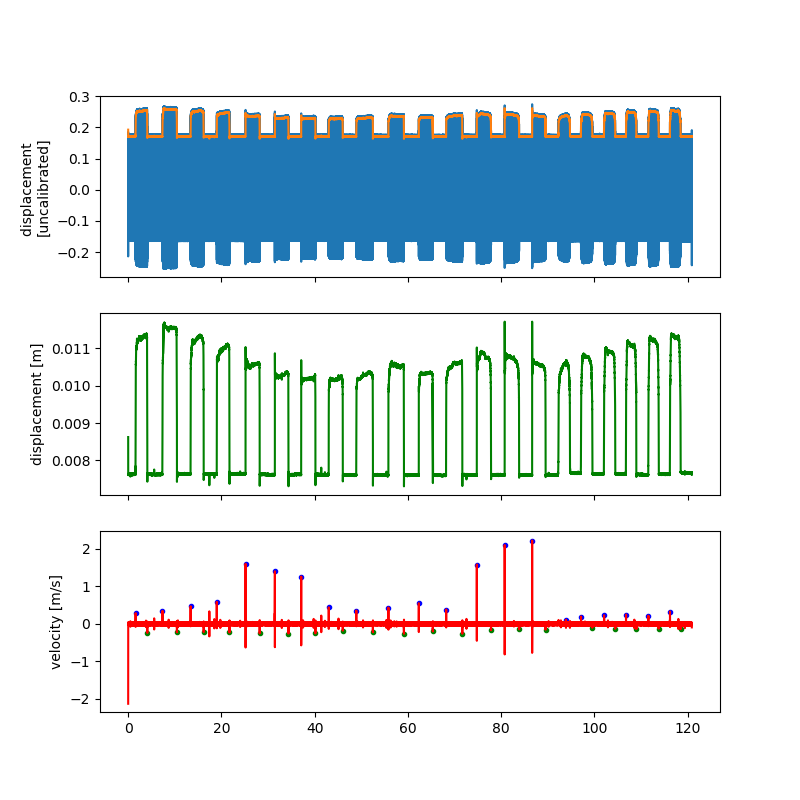

In [79]:
### Visual analysis of key displacement

delx = np.gradient(key_SI)
delt = np.gradient(t)
v_SI = delx/delt

fig,ax = plt.subplots(3,sharex=True,figsize=(8,8))
fig.set_label('keysignal')

ax[0].plot(np.arange(len(lightsig))/sr, lightsig)
ax[0].plot(t, key)
ax[0].set_ylabel('displacement \n[uncalibrated]')

ax[1].plot(t, key_SI, 'g')
ax[1].set_ylabel('displacement [m]')

ax[2].plot(t, v_SI, 'r')
ax[2].set_ylabel('velocity [m/s]')
ax[2].scatter(t_closing, v_closing, c='b', marker='.')
ax[2].scatter(t_opening, v_opening, c='g', marker='.')

<IPython.core.display.Javascript object>


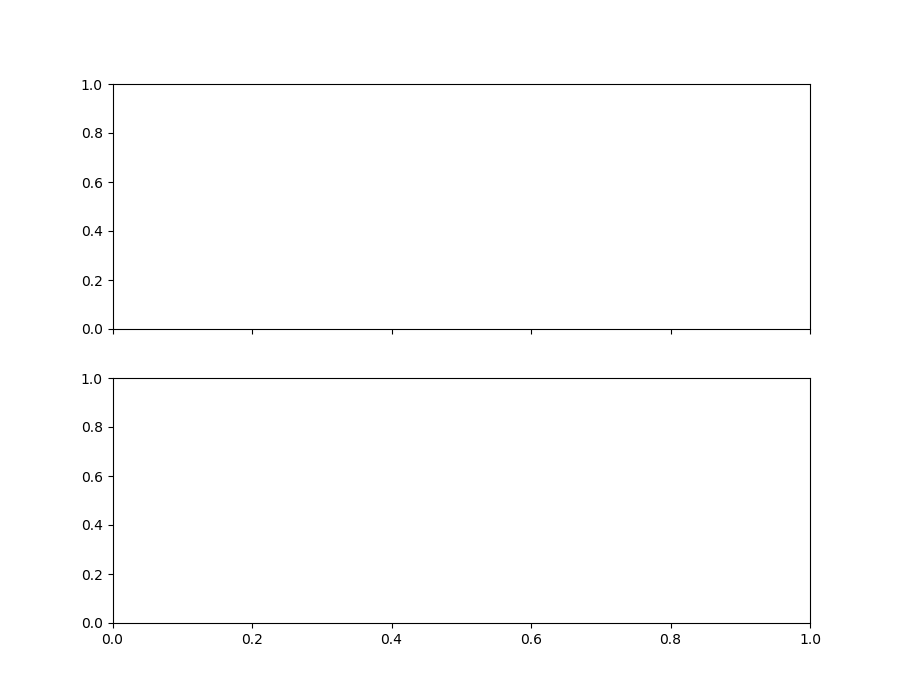

In [88]:
### Visual comparison of transitions

t_sr = len(t)/t[-1]

fig,ax = plt.subplots(2, sharex=True, figsize=(9,7))
fig.set_label('Fast transitions')

for i, audioclip in enumerate(audio_fast):
    print(audioclip)
    x_time = np.arange(len(audioclip))/sr
    ax[0].plot(x_time, audioclip)
    ax[0].set_xlabel('Time [s]')
    
for j, keyclip in enumerate(key_fast):
    x_time = np.arange(len(keyclip))/t_sr
    ax[1].plot(x_time, keyclip)
    ax[1].set_xlabel('Time [s]')

In [29]:
# clips = align(w2, key_SI, t, sr, 'audio')
# motion = align(w2, key_SI, t, sr, 'key')

# a_fast = clips[0]
# a_slow = clips[1]
# a_open = clips[2]
# k_fast = motion[0]
# k_slow = motion[1]
# k_open = motion[2]

# # fast = align(w2, key_SI, t, sr, 'audio')
# # slow = align(w2, key_SI, t, sr, 'audio')
# # opening = align(w2, key_SI, t, sr, 'audio')

# # keyfast = align(w2, key_SI, t, sr, 'key')
# # keyslow = align(w2, key_SI, t, sr, 'key')
# # keyopen = align(w2, key_SI, t, sr, 'key')

# len(a_fast), len(a_slow), len(a_open)

In [30]:
# def phasesync(audioclips, keysigs, sr):
#     a_times = []
#     k_times = []
    
#     for i in range(len(audioclips)):
#         clip = audioclips[i]
#         keyclip = keysigs[i]
#         reverse = clip[::-1]
#         last_min = (sig.argrelmin(reverse)[0][0])/sr
# #         last_max = (sig.argrelmax(reverse)[0][0])/sr
#         a_times.append([np.arange(len(clip))/sr + last_min])
#         k_times.append([np.arange(len(keyclip))*(1/2206) + last_min])
        
#     return a_times, k_times

# t_fast = phasesync(a_fast, k_fast, sr)
# t_slow = phasesync(a_slow, k_slow, sr)
# t_open = phasesync(a_open, k_open, sr)